# Imports

In [1]:
from google.colab import drive
import spacy
import torch.nn as nn
import torch
import random
import numpy as np
import pandas as pd
import torch.optim as optim
from tqdm import tqdm_notebook
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math

from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import random
import time
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [5]:
PATH_TRAIN = '/content/drive/MyDrive/NLP - Real or Not/train.csv'
PATH_VAL = '/content/drive/MyDrive/NLP - Real or Not/val.csv'
PATH_TEST = '/content/drive/MyDrive/NLP - Real or Not/test.csv'
PATH_SUB = '/content/drive/MyDrive/NLP - Real or Not/sample_submission.csv'
OUTPUT = '/content/drive/MyDrive/NLP - Real or Not/submission.csv'

In [ ]:
params = {
    'LR': 3e-4,
    'N_EPOCHS': 20,
    'BATCH_SZ': 32,
    'PAD_INDEX': 0,
    'N_VOCAB': 4000
    }

# Utils

In [7]:
  def remove_abbreviations(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r'\s+', " ", text)

    return text
  
  def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Initializing the Lemmatizer
    lem = WordNetLemmatizer()

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove common abbreviations
    text = remove_abbreviations(text)

    text = text.split()

    text = [lem.lemmatize(word) for word in text if word not in set(stopwords.words('english'))]
    text = [word for word in text if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    text = text.split()

    return text


def build_word2idx(train_path, n_vocab = 4000):
    df = pd.read_csv(train_path)
    text = df['text']
    words_count = {}

    for sent in text:
      sent_toks = text_preprocessing(sent)

      for tok in sent_toks:
        if tok not in words_count:
          words_count[tok] = 1

        else: words_count[tok] += 1

    word2idx = {'<PAD>':0, '<UNK>':1}
    idx = 2
    
    words_count = sorted(words_count.items(), key=lambda x: x[1], reverse=True)
    top_words = [w for w, count in words_count[:n_vocab-1]]

    for w in top_words:
      word2idx[w] = idx
      idx += 1
    
    return word2idx

def tokenizer_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Dataset

In [8]:
class DisasterTweets(Dataset):
  def __init__(self, file_path, word2idx, istest=False):
    super(DisasterTweets,self).__init__()
    self.df = pd.read_csv(file_path)
    self.id = self.df['id']
    self.text = self.df["text"]
    self.word2idx = word2idx

    if istest == False :
      self.label = self.df["target"]
    
    else: self.label = [0]*len(self.df)

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    txt = self.text[index]
    lab = self.label[index]
    id = self.id[index]
    tok_sent = text_preprocessing(txt)
    tok_ids = [self.word2idx[token] if token in self.word2idx else 1 for token in tok_sent]

    return lab, torch.tensor(tok_ids,dtype = torch.long), id

In [9]:
class MyCollate:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    label = [item[0] for item in batch]
    id = [item[2] for item in batch]
    tok_ids = [item[1] for item in batch]
    tok_ids = pad_sequence(sequences=tok_ids, batch_first = False, padding_value = self.pad_idx)

    return  tok_ids, label, id

In [21]:
def get_loader(
    annotation_file,
    word2idx,
    batch_size=32,
    num_workers = 0,
    shuffle = True,
    pin_memory = True,
    istest=False):
  
  pad_index = params['PAD_INDEX']
  
  dataset = DisasterTweets(annotation_file,word2idx,istest=istest)

  loader = DataLoader(
      dataset =dataset,
      batch_size = batch_size,
      num_workers = num_workers,
      shuffle = shuffle,
      pin_memory = pin_memory,
      collate_fn = MyCollate(pad_idx=pad_index)
  )

  return loader, dataset

# Model

In [22]:
# Positional encoding from Pytorch website

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [23]:
# Model with extra layers on top of RoBERTa
class CBOWClassifier(torch.nn.Module):
    def __init__(self, n_vocab, embedding_sz, dropout_rate=0.4, n_hidden = 20):
        super(CBOWClassifier, self).__init__() 
        self.pos_encoder = PositionalEncoding(embedding_sz, dropout_rate)
        self.embedding = nn.Embedding(n_vocab, embedding_sz, padding_idx=0)
        self.d1 = nn.Dropout(dropout_rate)
        self.l2 = nn.Linear(n_hidden, 2)
        self.l1 = nn.Linear(embedding_sz, n_hidden)
        
    def forward(self, tweet):
        x = self.embedding(tweet)
        x = self.pos_encoder(x)
        x = x.mean(dim=0)
        x = self.d1(x)
        x = torch.relu(self.l1(x))
        out = self.l2(x)
        
        return out

#Training

In [24]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [25]:
loss_fn = nn.CrossEntropyLoss()
def train_fn(model, train_loader, val_loader, optimizer, word2idx, num_epochs = 5):

      train_loss = 0.0
      valid_loss = 0.0
      train_loss_list = []
      valid_loss_list = []
      best_valid_loss = float('Inf')
      
      global_step = 0
      global_steps_list = []

      for epoch in range(num_epochs):
        model.train()
        for text, label, ids  in train_loader:

          tok_ids = text.to(device)
          label  = torch.tensor(label).to(device)

          y_pred = model(tok_ids)
          loss = loss_fn(y_pred, label)


          # Back prop
          loss.backward()

          # Clip to avoid exploding gradient issues, makes sure grads are
          # within a healthy range
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

          optimizer.step()

          optimizer.zero_grad()

          #model.embedding.weight.data[0] = 0

          train_loss += loss.item()
          global_step += 1

          if global_step%50 == 0:
            model.eval()

            with torch.no_grad():
            
              for text, label, ids in val_loader:
                  tok_ids = text.to(device)
                  label = torch.tensor(label).to(device)

                  y_pred = model(tok_ids)

                  loss = loss_fn(y_pred, label)
                  valid_loss += loss.item()

                
            # Store train and validation loss history
            train_loss = train_loss / 50
            valid_loss = valid_loss / len(val_loader)
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            global_steps_list.append(global_step)

            print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
            .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader), train_loss, valid_loss))

            # checkpoint
            if best_valid_loss > valid_loss:
                best_valid_loss = valid_loss
                """
                save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                """
                        
            train_loss = 0.0                
            valid_loss = 0.0
            model.train()
    
      """save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)"""
      print('Training done!')

# Evaluate

In [26]:
def evaluate_fn(model, val_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for text, label, ids in val_loader:

            tok_ids = text.to(device)
                
            output = model(tok_ids)
            _, pred = torch.max(output.data, 1)

            y_pred.extend(pred.tolist())
            y_true.extend(label)
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])


In [31]:
def submission(model, test_loader, test, path_sub = PATH_SUB):

  submission = pd.read_csv(PATH_SUB)

  predictions = []
  ids = []

  model.eval()

  with torch.no_grad():

    for text, _, id in test_loader:
      tok_ids = text.to(device)
      output = model(tok_ids)
      _, predicted =torch.max(output.data, 1)

      predictions.append(predicted)
      ids.append(id)
    
    predictions = torch.cat(predictions, dim=0)

    submission['id'] = [item for sublist in ids for item in sublist]
    submission['target'] = predictions.cpu()

  return submission

# Raw

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def run():

  n_vocab = params['N_VOCAB']
  n_epochs = params['N_EPOCHS']
  batch_sz = params['BATCH_SZ']

  word2idx = build_word2idx(PATH_TRAIN,n_vocab)

  train_loader, train = get_loader(PATH_TRAIN, word2idx,)
  val_loader, val = get_loader(PATH_VAL, word2idx)
  test_loader, test = get_loader(PATH_TEST, word2idx, shuffle = False, istest=True)

  #steps_per_epoch = len(train_loader)

  model = CBOWClassifier(4001, 300)
  model = model.to(device)

  print("======================= Start training =================================")
  optimizer = optim.Adam(model.parameters(), lr=params['LR'])

  train_fn(model=model, 
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        word2idx = word2idx, 
        num_epochs=n_epochs)


  evaluate_fn(model = model,
              val_loader = val_loader)

  
  sub = submission(model, test_loader, test, path_sub = PATH_SUB)

  return sub

======================= Start training =================================
Epoch [1/20], global step [50/3820], Train Loss: 0.6927, Valid Loss: 0.6823
Epoch [1/20], global step [100/3820], Train Loss: 0.6866, Valid Loss: 0.6799
Epoch [1/20], global step [150/3820], Train Loss: 0.6870, Valid Loss: 0.6795
Epoch [2/20], global step [200/3820], Train Loss: 0.6805, Valid Loss: 0.6781
Epoch [2/20], global step [250/3820], Train Loss: 0.6811, Valid Loss: 0.6779
Epoch [2/20], global step [300/3820], Train Loss: 0.6825, Valid Loss: 0.6750
Epoch [2/20], global step [350/3820], Train Loss: 0.6822, Valid Loss: 0.6726
Epoch [3/20], global step [400/3820], Train Loss: 0.6814, Valid Loss: 0.6712
Epoch [3/20], global step [450/3820], Train Loss: 0.6725, Valid Loss: 0.6698
Epoch [3/20], global step [500/3820], Train Loss: 0.6755, Valid Loss: 0.6658
Epoch [3/20], global step [550/3820], Train Loss: 0.6700, Valid Loss: 0.6645
Epoch [4/20], global step [600/3820], Train Loss: 0.6651, Valid Loss: 0.6605
Epoc

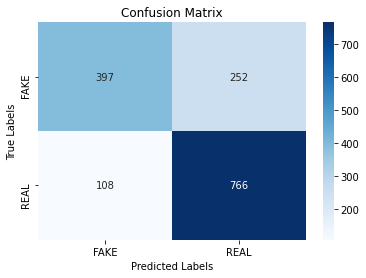

In [34]:
sub = run()

In [ ]:
sub.to_csv(OUTPUT, index=False)